<a href="https://colab.research.google.com/github/agusain2001/-AI-Powered-Document-/blob/main/bio_clinicalbert_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tune Bio_ClinicalBERT for Multi-Class Clinical Notes Classification

## Task 2: Multi-Class Classification of Clinical Notes (22 Categories)

**Objective:** Fine-tune Bio_ClinicalBERT to classify clinical note sentences into 22 medical categories.

**Categories:** diagnosis, symptoms, procedures, findings, medications, medical_history, social_history, family_history, plan_assessment, admission_source, discharge_disposition, poa_indicator, external_cause, cpt_modifiers, icd10_pcs, drg, revenue_code, impression, reason_for_visit, treatment, chief_complaints, other

## 1. Installation & Imports

In [1]:
!pip install transformers datasets accelerate scikit-learn seaborn -q

In [2]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch: 2.9.0+cu126
CUDA available: True


## 2. Configuration & Category Mapping

In [3]:
# Configuration
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5
SEED = 42

# Category mapping (22 classes)
CATEGORY_TO_ID = {
    "diagnosis": 0, "symptoms": 1, "procedures": 2, "findings": 3,
    "medications": 4, "medical_history": 5, "social_history": 6,
    "family_history": 7, "plan_assessment": 8, "admission_source": 9,
    "discharge_disposition": 10, "poa_indicator": 11, "external_cause": 12,
    "cpt_modifiers": 13, "icd10_pcs": 14, "drg": 15, "revenue_code": 16,
    "impression": 17, "reason_for_visit": 18, "treatment": 19,
    "chief_complaints": 20, "other": 21
}
ID_TO_CATEGORY = {v: k for k, v in CATEGORY_TO_ID.items()}
NUM_LABELS = len(CATEGORY_TO_ID)

print(f"Number of categories: {NUM_LABELS}")
print(f"Using model: {MODEL_NAME}")

Number of categories: 22
Using model: emilyalsentzer/Bio_ClinicalBERT


## 3. Load Dataset

In [4]:
def load_data(data_source):
    """Load data from JSON file or list"""
    if isinstance(data_source, str):
        with open(data_source, 'r') as f:
            data = json.load(f)
    else:
        data = data_source

    df = pd.DataFrame(data)
    df['label'] = df['category_id'].map(CATEGORY_TO_ID)

    if df['label'].isna().any():
        print(f"Warning: {df['label'].isna().sum()} unmapped categories")
        df = df.dropna(subset=['label'])

    df['label'] = df['label'].astype(int)
    return df

# Load the actual file
df = load_data("/content/test_data.json")
print(f"Dataset shape: {df.shape}")
print(f"\nCategory distribution:\n{df['category_id'].value_counts()}")

Dataset shape: (145, 3)

Category distribution:
category_id
findings            103
diagnosis            16
procedures           10
symptoms              5
plan_assessment       4
impression            3
reason_for_visit      2
other                 2
Name: count, dtype: int64


## 4. Handle Class Imbalance

**Decision:** Using weighted loss function to handle class imbalance.

In [5]:
def compute_weights(labels):
    """Compute class weights for imbalanced data"""
    unique_labels = np.unique(labels)
    weights = compute_class_weight('balanced', classes=unique_labels, y=labels)

    full_weights = np.ones(NUM_LABELS)
    for idx, label in enumerate(unique_labels):
        full_weights[label] = weights[idx]

    return torch.FloatTensor(full_weights)

class_weights = compute_weights(df['label'].values)
print(f"Class weights shape: {class_weights.shape}")

Class weights shape: torch.Size([22])


## 5. Dataset Class & Tokenization

In [6]:
class ClinicalNotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenizer loaded: emilyalsentzer/Bio_ClinicalBERT


In [12]:
# Note: For small datasets, stratification may fail if any class has < 2 samples
# We use a try-except pattern to fall back to non-stratified split if needed

from collections import Counter

def safe_stratified_split(texts, labels, test_size, random_state, min_samples_per_class=2):
    """Perform stratified split if possible, otherwise fall back to random split"""
    label_counts = Counter(labels)
    can_stratify = all(count >= min_samples_per_class for count in label_counts.values())

    if can_stratify:
        return train_test_split(texts, labels, test_size=test_size,
                               random_state=random_state, stratify=labels)
    else:
        print(f"Warning: Cannot stratify - some classes have < {min_samples_per_class} samples. Using random split.")
        return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

# First split: 70% train, 30% temp
train_texts, temp_texts, train_labels, temp_labels = safe_stratified_split(
    df['sentence'].tolist(), df['label'].tolist(),
    test_size=0.3, random_state=SEED
)

# Second split: 50% val, 50% test (from temp)
val_texts, test_texts, val_labels, test_labels = safe_stratified_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=SEED
)

print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")

# Create datasets
train_dataset = ClinicalNotesDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = ClinicalNotesDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = ClinicalNotesDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

Train: 101, Val: 22, Test: 22


## 6. Model Setup with Weighted Loss

In [13]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=ID_TO_CATEGORY,
    label2id=CATEGORY_TO_ID
)
print(f"Model loaded with {NUM_LABELS} output labels")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 22 output labels


## 7. Training Configuration

| Aspect | Decision | Rationale |
|--------|----------|----------|
| Loss | Weighted CrossEntropy | Handles class imbalance |
| Optimizer | AdamW | Standard for transformers |
| LR Schedule | Linear warmup (10%) | Prevents early instability |
| Early Stopping | Patience=2 | Prevents overfitting |

In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=10,
    seed=SEED,
    report_to="none"
)

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
        'f1_weighted': f1_score(labels, preds, average='weighted', zero_division=0)
    }

In [17]:
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

## 8. Training

In [18]:
print("Starting training...")
trainer.train()
print("Training completed!")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,2.730810,0.772727,0.217949,0.713287
2,2.861700,2.536982,0.818182,0.230769,0.755245
3,2.701200,2.493175,0.818182,0.230769,0.755245
4,2.701200,2.494326,0.772727,0.217949,0.713287


Training completed!


## 9. Evaluation

In [19]:
test_results = trainer.evaluate(test_dataset)
print("Test Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

Test Results:
  eval_loss: 2.6671
  eval_accuracy: 0.5909
  eval_f1_macro: 0.1016
  eval_f1_weighted: 0.4801
  eval_runtime: 0.3688
  eval_samples_per_second: 59.6520
  eval_steps_per_second: 5.4230
  epoch: 4.0000


In [20]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

present_labels = sorted(set(test_labels))
target_names = [ID_TO_CATEGORY[i] for i in present_labels]

print("Classification Report:")
print(classification_report(test_labels, preds, labels=present_labels,
                          target_names=target_names, zero_division=0))

Classification Report:
                 precision    recall  f1-score   support

      diagnosis       0.00      0.00      0.00         2
       symptoms       0.00      0.00      0.00         1
     procedures       0.00      0.00      0.00         3
       findings       0.68      1.00      0.81        13
plan_assessment       0.00      0.00      0.00         1
     impression       0.00      0.00      0.00         1
          other       0.00      0.00      0.00         1

      micro avg       0.62      0.59      0.60        22
      macro avg       0.10      0.14      0.12        22
   weighted avg       0.40      0.59      0.48        22



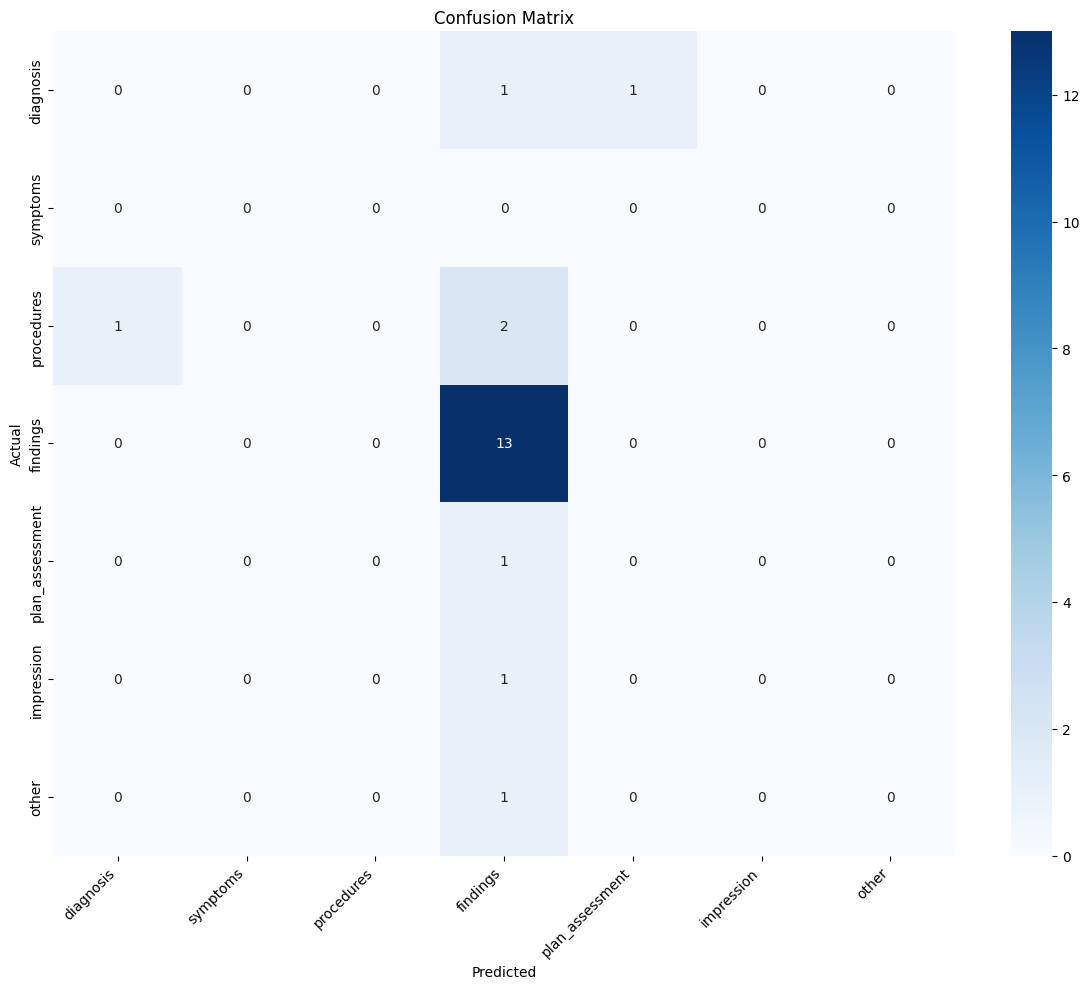

In [21]:
def plot_confusion_matrix(y_true, y_pred, labels, figsize=(12, 10)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[ID_TO_CATEGORY[l] for l in labels],
                yticklabels=[ID_TO_CATEGORY[l] for l in labels])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_labels, preds, present_labels)

## 10. Save Model

In [22]:
model.save_pretrained('./bio_clinicalbert_clinical_notes')
tokenizer.save_pretrained('./bio_clinicalbert_clinical_notes')
print("Model saved to ./bio_clinicalbert_clinical_notes")

Model saved to ./bio_clinicalbert_clinical_notes


## 11. Inference Example

In [23]:
def predict_category(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True,
                       max_length=MAX_LENGTH, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    pred_id = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][pred_id].item()

    return ID_TO_CATEGORY[pred_id], confidence

# Test
sample = "Patient presents with chest pain and shortness of breath."
category, conf = predict_category(sample)
print(f"Text: {sample}")
print(f"Predicted: {category} (confidence: {conf:.2%})")

Text: Patient presents with chest pain and shortness of breath.
Predicted: findings (confidence: 10.25%)


## 12. Documentation: Design Decisions

| Aspect | Decision | Rationale |
|--------|----------|----------|
| **Model** | Bio_ClinicalBERT | Pre-trained on clinical text (MIMIC-III) |
| **Max Length** | 256 tokens | Balance context vs memory |
| **Loss** | Weighted CrossEntropy | Handles class imbalance |
| **Optimizer** | AdamW | Standard for transformers |
| **LR Schedule** | Linear warmup (10%) | Prevents instability |
| **Early Stopping** | Patience=2 | Prevents overfitting |
| **Eval Metric** | F1-macro | Fair for imbalanced data |
| **Batch Size** | 16 | Memory-efficient |